# PyVisa direct use of QDAC-II


In [1]:
from time import sleep
from IPython.display import Image, display
import numpy
import pyvisa as visa
qdac_addr = '192.168.8.17'
rm = visa.ResourceManager('@py')  # Use pyvisa-py
dac = rm.open_resource(f'TCPIP::{qdac_addr}::5025::SOCKET')
dac.write_termination = '\n'
dac.read_termination = '\n'
print(dac.query('*idn?'))
from qcodes.instrument_drivers.rigol import RigolDS1074Z
rigol_addr = '192.168.8.199'
scope = RigolDS1074Z('rigol', visalib='@py', address=f'TCPIP::{rigol_addr}::INSTR')

QDevil, QDAC-II, 3, 10-1.4
Connected to: RIGOL TECHNOLOGIES DS1104Z (serial:DS1ZA171812151, firmware:00.04.03) in 0.11s


In [2]:
def capture():
    scope.write('stop')
    scope.write(":disp:data?")
    bmpdata = scope.visa_handle.read_raw()[2+9:]
    image = Image(data=bmpdata)
    display(image)

In [3]:
dac.write('*rst')
scope.write('*rst')
sleep(3)

In [4]:
# Connect scope ch 3 to qdac ch 3
scope.write('chan1:disp off')
scope.write('chan3:disp on')
scope.write('chan3:bwl on')
scope.write('chan3:prob 1')
scope.write('chan3:scal 100e-3')
scope.write('chan3:offs 0.0')
scope.write('trig:edge:sour chan3')
scope.write('trig:edge:level 0.005')
scope.write('tim:scal 50e-6')
scope.write('tim:offs 0e-6')

In [5]:
# How does the numpy repetition functions work?
xs = numpy.tile(numpy.array([0.1, 0.2]), 3)
print(xs)
ys = numpy.repeat(numpy.array([0.1, 0.2]), 3)
print(ys)

[0.1 0.2 0.1 0.2 0.1 0.2]
[0.1 0.1 0.1 0.2 0.2 0.2]


In [6]:
channel = 3
size = 1000
steps = 20  # must divide size
repetitions = 1000000

dac.write('trac:rem:all')
dac.write(f'trac:def "mysquare",{size}')
awg = numpy.tile(numpy.repeat([0, 0.01], 5), (size // 10))
print(len(awg))
dac.write_binary_values(f'trac:data "mysquare",', awg)

dac.write(f'sour{channel}:awg:def "mysquare"')
dac.write(f'sour{channel}:awg:coun {repetitions}')
dac.write(f'sour{channel}:awg:trig:sour int1')
dac.write(f'sour{channel}:awg:init:cont off')
dac.write(f'sour{channel}:awg:init')

stairs = numpy.repeat(numpy.arange(-2.0, 2.0, 4.0/steps), (size // steps))
#print(stairs)
print(len(stairs))
dac.write_binary_values(f'sour{channel}:list:volt ', stairs)
dac.write(f'sour{channel}:volt:mode list')
dac.write(f'sour{channel}:list:dwel 2e-6')
dac.write(f'sour{channel}:list:coun {repetitions}')
dac.write(f'sour{channel}:dc:trig:sour int1')
dac.write(f'sour{channel}:dc:init:cont off')
dac.write(f'sour{channel}:dc:init')

dac.query('syst:err:all?')

1000
1000


'0, "No error"'

In [7]:
scope.write('run')
dac.write('tint 1')
dac.query('syst:err:all?')

'0, "No error"'

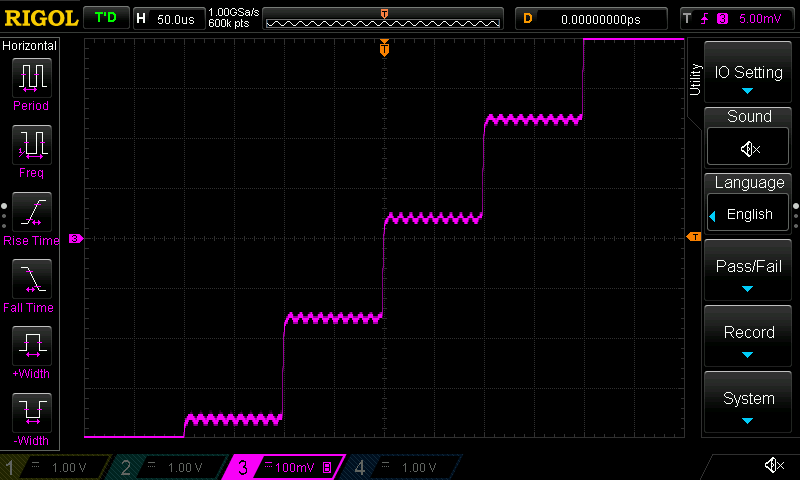

In [13]:
capture()